Этот файлик содержит решение четвёртой задачки - про колл-центр. 

Решение не очень интересное: фича-инжиниринг и подбор параметров катбуста. Удивительно, что предложенный нам бейзлайн вообще использовал очевидно более слабые линейные классификаторы. 

Фичи: 
* все моменты времени - в секундах от полуночи, и синус-косинус часовой/минутной/секундной стрелки. 
* индикаторы пропусков всех признаков
* время между всеми событиями
* доли каждого этапа (гудки, постановка в очередь, разговор с оператором) от всего времени звонка. 
* разница проставленного времени звонка разговора с оператором и рассчитанного по началу-концу
* пробовал ещё разные линейные функции от этих фич, но они не принесли профита 

Удивительно, но абсолютное время в очереди (достаточно большое) и время суток (глубокая ночь) оказались суперфичами, дающими большую часть предсказательной силы. Этому есть некоторое логическое объяснение: чем дольше звонок в очереди, тем стыднее (и тем больше стимулов врать), а ночью операторов меньше всего, и это тоже, видимо, увеличивает время ожидания. Тем не менее, у меня были большие опасения, что мы переобучимся на эти фичи, а в тестовом сете зависимость от них будет другой. Но вроде бы этого не произошло. 

## подготовка данных

In [0]:
!wget https://github.com/datasouls/nlp-hack-2019/raw/master/data/callcenter_train.csv

In [0]:
!pip install catboost

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
all_data = pd.read_csv('callcenter_train.csv')

In [4]:
all_data.shape

(30804, 8)

In [530]:
all_data.sample(20).sort_values("Метка")


,id,Время начала вызова,Время окончания вызова,Время постановки в очередь,Время переключения на оператора,Время окончания разговора с оператором,"Длительность разговора с оператором, сек",Метка
23688,23688,12:59:56,13:01:20,12:59:56,12:59:56,13:01:17,81.0,0
21685,21685,12:00:05,12:02:58,12:01:13,12:01:13,12:02:54,101.0,0
10594,10594,19:51:40,19:54:28,19:52:48,19:52:48,19:53:49,61.0,0
18613,18613,21:02:33,21:02:43,NaN,NaN,NaN,NaN,0
7658,7658,16:28:52,16:33:40,16:29:56,NaN,NaN,NaN,0
26725,26725,21:11:41,21:14:41,21:12:21,21:12:21,21:14:40,139.0,0
8995,8995,10:20:43,10:23:33,10:21:16,10:22:09,10:23:33,84.0,0
26084,26084,15:48:53,15:49:39,NaN,NaN,NaN,NaN,0
28069,28069,14:14:59,14:23:18,14:16:07,14:16:16,14:22:52,396.0,0
27009,27009,04:18:45,04:19:55,NaN,NaN,NaN,NaN,0


In [453]:
all_data.isnull().mean()

id                                          0.000000
Время начала вызова                         0.000000
Время окончания вызова                      0.000032
Время постановки в очередь                  0.278308
Время переключения на оператора             0.395111
Время окончания разговора с оператором      0.395403
Длительность разговора с оператором, сек    0.395079
Метка                                       0.000000
dtype: float64

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
all_train, all_test0 = train_test_split(all_data, random_state=1, test_size=0.3)
all_test, all_valid = train_test_split(all_test0, random_state=1, test_size=0.3)

## тренируемся работать со временем

In [8]:
all_train['Время начала вызова'].iloc[0]

'09:48:36'

In [10]:
pd.to_datetime(all_train['Время постановки в очередь'].iloc[0:10])

27326                   NaT
1114    2019-12-15 15:18:16
8517    2019-12-15 23:01:54
28473   2019-12-15 16:38:32
26942   2019-12-15 01:28:23
25674   2019-12-15 12:47:02
19875   2019-12-15 14:09:09
29505                   NaT
20217   2019-12-15 16:28:23
1256    2019-12-15 16:19:52
Name: Время постановки в очередь, dtype: datetime64[ns]

In [11]:

all_data.columns

Index(['id', 'Время начала вызова', 'Время окончания вызова',
       'Время постановки в очередь', 'Время переключения на оператора',
       'Время окончания разговора с оператором',
       'Длительность разговора с оператором, сек', 'Метка'],
      dtype='object')

In [20]:

pd.to_datetime(all_train['Время окончания разговора с оператором'])

27326                   NaT
1114    2019-12-15 15:19:33
8517    2019-12-15 23:07:53
28473   2019-12-15 16:41:34
26942                   NaT
                ...        
17289   2019-12-15 05:17:10
5192    2019-12-15 10:39:11
12172   2019-12-15 15:11:38
235                     NaT
29733                   NaT
Name: Время окончания разговора с оператором, Length: 21562, dtype: datetime64[ns]

## Собственно, извлечение признаков

In [0]:
DUR_RU = 'Длительность разговора с оператором, сек'
DUR_EN = 'oper_duration'

In [0]:
RU_COLS = ['Время начала вызова', 'Время окончания вызова', 'Время постановки в очередь', 'Время переключения на оператора', 'Время окончания разговора с оператором',]
EN_COLS = ['call_start_time', 'call_end_time', 'queue_time', 'oper_start_time', 'oper_end_time']

zero_time = pd.to_datetime('00:00:00')

In [0]:
SEC_PER_DAY = 60*60*24

In [0]:

NA_VALUE = -1.2345


def extract_features(data):
    times = data[RU_COLS].apply(pd.to_datetime)
    times.columns = EN_COLS
    
    abs_times = times.apply(lambda x: (x-zero_time).dt.total_seconds()).fillna(NA_VALUE)
    abs_times.columns = [c+'_abs' for c in EN_COLS]

    day = abs_times / SEC_PER_DAY * 2 * np.pi
    hour = (abs_times % (24*60)) / (24*60) * 2 * np.pi
    minute = (abs_times % 60) / 60 * 2 * np.pi
    day_sines = np.sin(day)
    day_cosines = np.cos(day)
    hour_sines = np.sin(hour)
    hour_cosines = np.cos(hour)
    minute_sines = np.sin(minute)
    minute_cosines = np.cos(minute)

    day_sines.columns = ['day_sin__'+c for c in EN_COLS]
    day_cosines.columns = ['day_cos__'+c for c in EN_COLS]
    hour_sines.columns = ['hour_sin__'+c for c in EN_COLS]
    hour_cosines.columns = ['hour_cos__'+c for c in EN_COLS]
    minute_sines.columns = ['minute_sin__'+c for c in EN_COLS]
    minute_cosines.columns = ['minute_cos__'+c for c in EN_COLS]

    null_times = times.isnull().astype(int)
    null_times.columns = [c+"_miss" for c in EN_COLS]

    diffs = pd.DataFrame(index=times.index)
    for i, c1 in enumerate(EN_COLS):
        for j, c2 in enumerate(EN_COLS[(i+1):]):
            diffs['delta_{}_{}'.format(c1, c2)] = (times[c2] - times[c1]).dt.total_seconds().fillna(NA_VALUE)
    
    deltas_base = 'delta_call_start_time_call_end_time'

    for c in diffs.columns:
        d = diffs[c] / diffs[deltas_base]
        diffs['rel_{}'.format(c)] = d
    
    x = pd.concat([abs_times, day_sines, day_cosines, hour_sines, hour_cosines, minute_sines, minute_cosines, null_times, diffs], axis=1)
    x[DUR_EN] = data[DUR_RU].fillna(NA_VALUE)
    x[DUR_EN+'_miss'] = data[DUR_RU].isnull().astype(int)

    devia = x['delta_oper_start_time_oper_end_time'] - x[DUR_EN]
    devia[x['oper_duration_miss']==1] = 0
    devia[x['delta_oper_start_time_oper_end_time'] < 0] = 0

    x['oper_time_deviation'] = devia

    return x

In [0]:
train_x = extract_features(all_train)
test_x = extract_features(all_test)
valid_x = extract_features(all_valid)
train_y = all_train['Метка']
test_y = all_test['Метка']
valid_y = all_valid['Метка']

In [308]:


train_x.columns

Index(['call_start_time_abs', 'call_end_time_abs', 'queue_time_abs',
       'oper_start_time_abs', 'oper_end_time_abs', 'day_sin__call_start_time',
       'day_sin__call_end_time', 'day_sin__queue_time',
       'day_sin__oper_start_time', 'day_sin__oper_end_time',
       'day_cos__call_start_time', 'day_cos__call_end_time',
       'day_cos__queue_time', 'day_cos__oper_start_time',
       'day_cos__oper_end_time', 'hour_sin__call_start_time',
       'hour_sin__call_end_time', 'hour_sin__queue_time',
       'hour_sin__oper_start_time', 'hour_sin__oper_end_time',
       'hour_cos__call_start_time', 'hour_cos__call_end_time',
       'hour_cos__queue_time', 'hour_cos__oper_start_time',
       'hour_cos__oper_end_time', 'minute_sin__call_start_time',
       'minute_sin__call_end_time', 'minute_sin__queue_time',
       'minute_sin__oper_start_time', 'minute_sin__oper_end_time',
       'minute_cos__call_start_time', 'minute_cos__call_end_time',
       'minute_cos__queue_time', 'minute_cos__ope

In [524]:
has_dlit = train_x[train_x.oper_duration_miss== 0] 
has_dlit_y = train_y[train_x.oper_duration_miss== 0]
has_dlit.shape

(13052, 63)

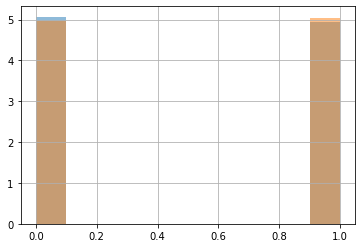

In [529]:
(has_dlit.oper_duration[has_dlit_y==1] % 2).hist(density=True, alpha=0.5)
(has_dlit.oper_duration[has_dlit_y==0] % 2).hist(density=True, alpha=0.5)

In [309]:
train_x['delta_oper_start_time_oper_end_time'].max()

2966.0

(0, 3000)

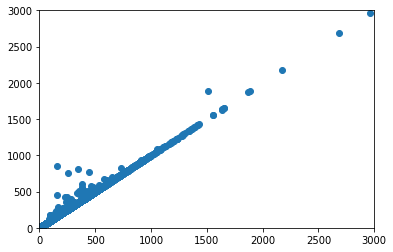

In [310]:

plt.scatter(train_x[DUR_EN], train_x['delta_oper_start_time_oper_end_time'])
plt.xlim(0, 3000)
plt.ylim(0, 3000)

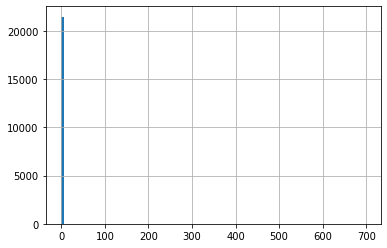

In [307]:
train_x.oper_time_deviation.hist(bins=100)

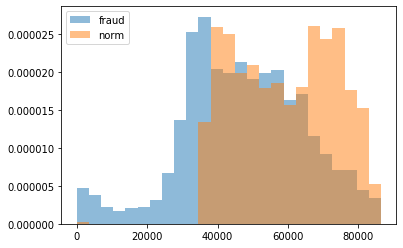

In [513]:
ff =  (train_x.oper_end_time_abs > 0)

xx1 = train_x[ff & (train_y==1)]
xx2 = train_x[ff& (train_y==0)]

c, b, _ = plt.hist(xx1.oper_end_time_abs, bins=25, alpha=0.5, density=True)
c, b, _ = plt.hist(xx2.oper_end_time_abs, bins=b, alpha=0.5, density=True);
plt.legend(['fraud', 'norm'])

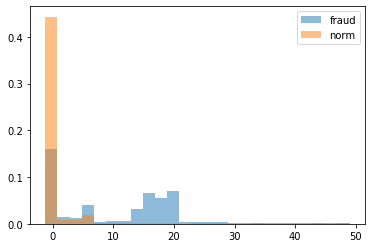

In [484]:
xx1 = train_x[(train_x.delta_queue_time_oper_start_time< 50) & (train_y==1)]
xx2 = train_x[(train_x.delta_queue_time_oper_start_time< 50) & (train_y==0)]

c, b, _ = plt.hist(xx1.delta_queue_time_oper_start_time, bins=25, alpha=0.5, density=True)
c, b, _ = plt.hist(xx2.delta_queue_time_oper_start_time, bins=b, alpha=0.5, density=True);
plt.legend(['fraud', 'norm'])

In [0]:
train_x[train_]

In [471]:
train_x.delta_queue_time_oper_start_time.groupby(train_y).describe()

,count,mean,std,min,25%,50%,75%,max
Метка,,,,,,,,
0,13537.0,9.258104,51.151799,-1.2345,-1.2345,-1.2345,0.0,806.0
1,8025.0,28.230901,65.880582,-1.2345,0.0000,15.0000,19.0,825.0


In [311]:

train_x.isnull().mean().mean(), test_x.isnull().mean().mean(), train_x.shape, test_x.shape

(0.0, 0.0, (21562, 53), (6469, 53))

In [0]:
from catboost import CatBoostClassifier, Pool

Неудачный эксперимент - фича из линейного классификатора. Профита особо не дала. 

```
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=10000, solver='lbfgs')
lr.fit(train_x, train_y)
print(f1_score(test_y, lr.predict(test_x)))

for t in (train_x, test_x, valid_x):
    if 'logreg_score' in test_x.columns:
        t.drop('logreg_score', inplace=True, axis=1)
logreg_train = cross_val_predict(lr, train_x, train_y, method='predict_proba')[:, 1]
train_x['logreg_score'] = logreg_train
test_x['logreg_score'] = lr.predict_proba(test_x)[:, 1]
valid_x['logreg_score'] = lr.predict_proba(valid_x)[:, 1]
```

Ещё один неудачный эксперимент - PCA-фичи
```
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

n_comp = 10
pca_colnames = ['pca_{}'.format(i) for i in range(n_comp)]

pca = make_pipeline(
    StandardScaler(),
    PCA(n_components=n_comp),
)

for t in (train_x, test_x, valid_x):
    if 'pca_0' in test_x.columns:
        t.drop(pca_colnames, inplace=True, axis=1)

pca.fit(train_x)


for t in (train_x, test_x, valid_x):
    pca_df = pd.DataFrame(pca.transform(t), columns=pca_colnames)
    for c in pca_colnames:
        t[c] = 0
    t[pca_colnames] = pca_df

plt.plot(np.cumsum(pca.steps[-1][1].explained_variance_ratio_))
```

## обучаем модель и подбираем параметры

In [592]:
eval_set = Pool(data=test_x, label=test_y)
clf = CatBoostClassifier(
    n_estimators=1000, learning_rate=0.005, 
    use_best_model=True, eval_metric='AUC', random_seed=1,
    grow_policy='SymmetricTree', depth=6,
    rsm=0.5,
)
clf.fit(train_x, train_y, eval_set=eval_set)

0:	test: 0.9242489	best: 0.9242489 (0)	total: 27.6ms	remaining: 27.5s
1:	test: 0.9307170	best: 0.9307170 (1)	total: 53.3ms	remaining: 26.6s
2:	test: 0.9338353	best: 0.9338353 (2)	total: 77.4ms	remaining: 25.7s
3:	test: 0.9348804	best: 0.9348804 (3)	total: 103ms	remaining: 25.8s
4:	test: 0.9366899	best: 0.9366899 (4)	total: 128ms	remaining: 25.5s
5:	test: 0.9375189	best: 0.9375189 (5)	total: 154ms	remaining: 25.4s
6:	test: 0.9374581	best: 0.9375189 (5)	total: 180ms	remaining: 25.5s
7:	test: 0.9376407	best: 0.9376407 (7)	total: 205ms	remaining: 25.4s
8:	test: 0.9374992	best: 0.9376407 (7)	total: 237ms	remaining: 26.1s
9:	test: 0.9373343	best: 0.9376407 (7)	total: 263ms	remaining: 26s
10:	test: 0.9373881	best: 0.9376407 (7)	total: 288ms	remaining: 25.9s
11:	test: 0.9375298	best: 0.9376407 (7)	total: 313ms	remaining: 25.8s
12:	test: 0.9375353	best: 0.9376407 (7)	total: 339ms	remaining: 25.7s
13:	test: 0.9379193	best: 0.9379193 (13)	total: 365ms	remaining: 25.7s
14:	test: 0.9378828	best: 0.

In [0]:
test_pred = clf.predict(test_x)
valid_pred = clf.predict(valid_x)

In [0]:
test_proba = clf.predict_proba(test_x)[:, 1]
valid_proba = clf.predict_proba(valid_x)[:, 1]

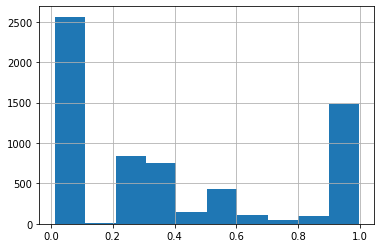

In [595]:
pd.Series(test_proba).hist();

In [596]:

test_pred.mean(), test_y.mean(), (test_proba>0.42).mean()


(0.3352913897047457, 0.3705364043901685, 0.3530684804452002)

In [0]:
from sklearn.metrics import f1_score

In [598]:
print(f1_score(test_y, test_pred))

0.8098992553657468


In [599]:
print(f1_score(test_y, test_proba>0.41))

0.8193438432040904


Выбираем оптимальный порог отсечения

0.40816326530612246


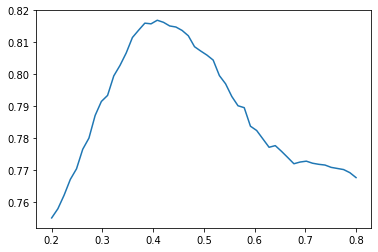

In [570]:
thresholds = np.linspace(0.2, 0.8, num=50)
scores = np.array([f1_score(test_y, test_proba>t) for t in thresholds])
plt.plot(thresholds, scores);
print(thresholds[scores.argmax()])

В ходе экспериментов я менял композицию тестовой выборки и некоторые сиды, поэтому не все числа тут сопоставимы друг с другом. Но можно видеть, что при использовании F-скора как метрики очень важно подобрать оптимальный порог. И ещё заметен последний шаг - катбуст, глядя на "тестовую" выборку, выбирает почему-то слишком много деревьев. Видимо, оптимумы ROC-AUC и F1 существенно разные, и деревья после тысячного уже не особо улучшают скоры около моего кастомного порога отсечения, а только где-то в хвостах распределения. 

* Бейзлайн - 80.3
* Добавил тригонометрию и потюнил lr - 80.579
* Потюнил порог - 81.47
* Добавил логрег фичу - 81.49
* Добавил PCA-фичи - всё только упало
* Стоппинг по AUC = 81.76 / 80.45
* Уменьшил LR = 81.8 / 80.87
* Уменьшил глубину = 81.8 / 81.04
* Текущее 81.56 / 80.36
* RSM 0.5 =  81.46 / 80.16
* smaller lr, more trees = 81.64 / 80.40
* less trees = 81.93, 80.70

In [600]:
print(f1_score(valid_y, valid_pred))
print(f1_score(valid_y, valid_proba>0.41))

0.8025013027618552
0.8070528967254408


In [0]:
pd.options.display.max_rows = 200

Очень важно посмотреть на важность фичей. 

Видим, что время звонка в очереди - суперфича. И время суток тоже. 

Именно поэтому выше я нарисовал гистограмки и этих фич, не поверил в увиденное, и решил применить rsm, чтобы уменьшить их влияние на итоговый прогноз. 

In [581]:
pd.Series(clf.feature_importances_, index=train_x.columns)

call_start_time_abs                           2.951886
call_end_time_abs                             3.271528
queue_time_abs                                3.554524
oper_start_time_abs                           5.159916
oper_end_time_abs                             4.586468
day_sin__call_start_time                      1.662012
day_sin__call_end_time                        1.154483
day_sin__queue_time                           1.836756
day_sin__oper_start_time                      5.810892
day_sin__oper_end_time                        7.267555
day_cos__call_start_time                      0.596379
day_cos__call_end_time                        0.609699
day_cos__queue_time                           0.834917
day_cos__oper_start_time                      1.448565
day_cos__oper_end_time                        2.604624
hour_sin__call_start_time                     0.284485
hour_sin__call_end_time                       0.368895
hour_sin__queue_time                          0.271160
hour_sin__

In [601]:
best_it = clf.best_iteration_
print(best_it)

998


Обучим выбранную модель на всех данных. А что, жалко же 30% выборки терять!

In [0]:
all_x = extract_features(all_data)
all_y = all_data['Метка']
assert (all_x.columns == train_x.columns).all()

In [0]:
params = clf.get_all_params()
params['iterations'] = clf.best_iteration_
params['use_best_model'] = False

In [0]:
del params['bayesian_matrix_reg']
del params['permutation_count']

In [605]:
clf2 = CatBoostClassifier(**params)
clf2.fit(all_x, all_y, use_best_model=False)

0:	total: 27.7ms	remaining: 27.6s
1:	total: 55ms	remaining: 27.4s
2:	total: 80.2ms	remaining: 26.6s
3:	total: 107ms	remaining: 26.5s
4:	total: 133ms	remaining: 26.4s
5:	total: 158ms	remaining: 26.2s
6:	total: 185ms	remaining: 26.2s
7:	total: 211ms	remaining: 26.1s
8:	total: 241ms	remaining: 26.5s
9:	total: 267ms	remaining: 26.4s
10:	total: 293ms	remaining: 26.3s
11:	total: 318ms	remaining: 26.1s
12:	total: 348ms	remaining: 26.3s
13:	total: 374ms	remaining: 26.3s
14:	total: 401ms	remaining: 26.3s
15:	total: 429ms	remaining: 26.3s
16:	total: 460ms	remaining: 26.5s
17:	total: 486ms	remaining: 26.5s
18:	total: 513ms	remaining: 26.4s
19:	total: 539ms	remaining: 26.4s
20:	total: 566ms	remaining: 26.3s
21:	total: 592ms	remaining: 26.3s
22:	total: 618ms	remaining: 26.2s
23:	total: 644ms	remaining: 26.1s
24:	total: 674ms	remaining: 26.2s
25:	total: 701ms	remaining: 26.2s
26:	total: 731ms	remaining: 26.3s
27:	total: 758ms	remaining: 26.3s
28:	total: 786ms	remaining: 26.3s
29:	total: 819ms	remain

In [0]:
clf2.save_model('call_center.model')

In [0]:
from google.colab import files
files.download('call_center.model') 